# Gọi thư viện cần thiết 

In [5]:
import numpy as np
from PIL import Image, ImageFont, ImageDraw
from PIL.ImageChops import add, subtract, multiply, difference, screen
import PIL.ImageStat as stat
from skimage.io import imread, imsave, imshow, show, imread_collection, imshow_collection
from skimage import color, exposure, img_as_float, data
from skimage.transform import SimilarityTransform, warp, swirl
from skimage.util import invert, random_noise, montage
import matplotlib.image as mpimg
import matplotlib.pylab as plt
from scipy.ndimage import affine_transform, zoom
from scipy import misc

# Image Inpainting

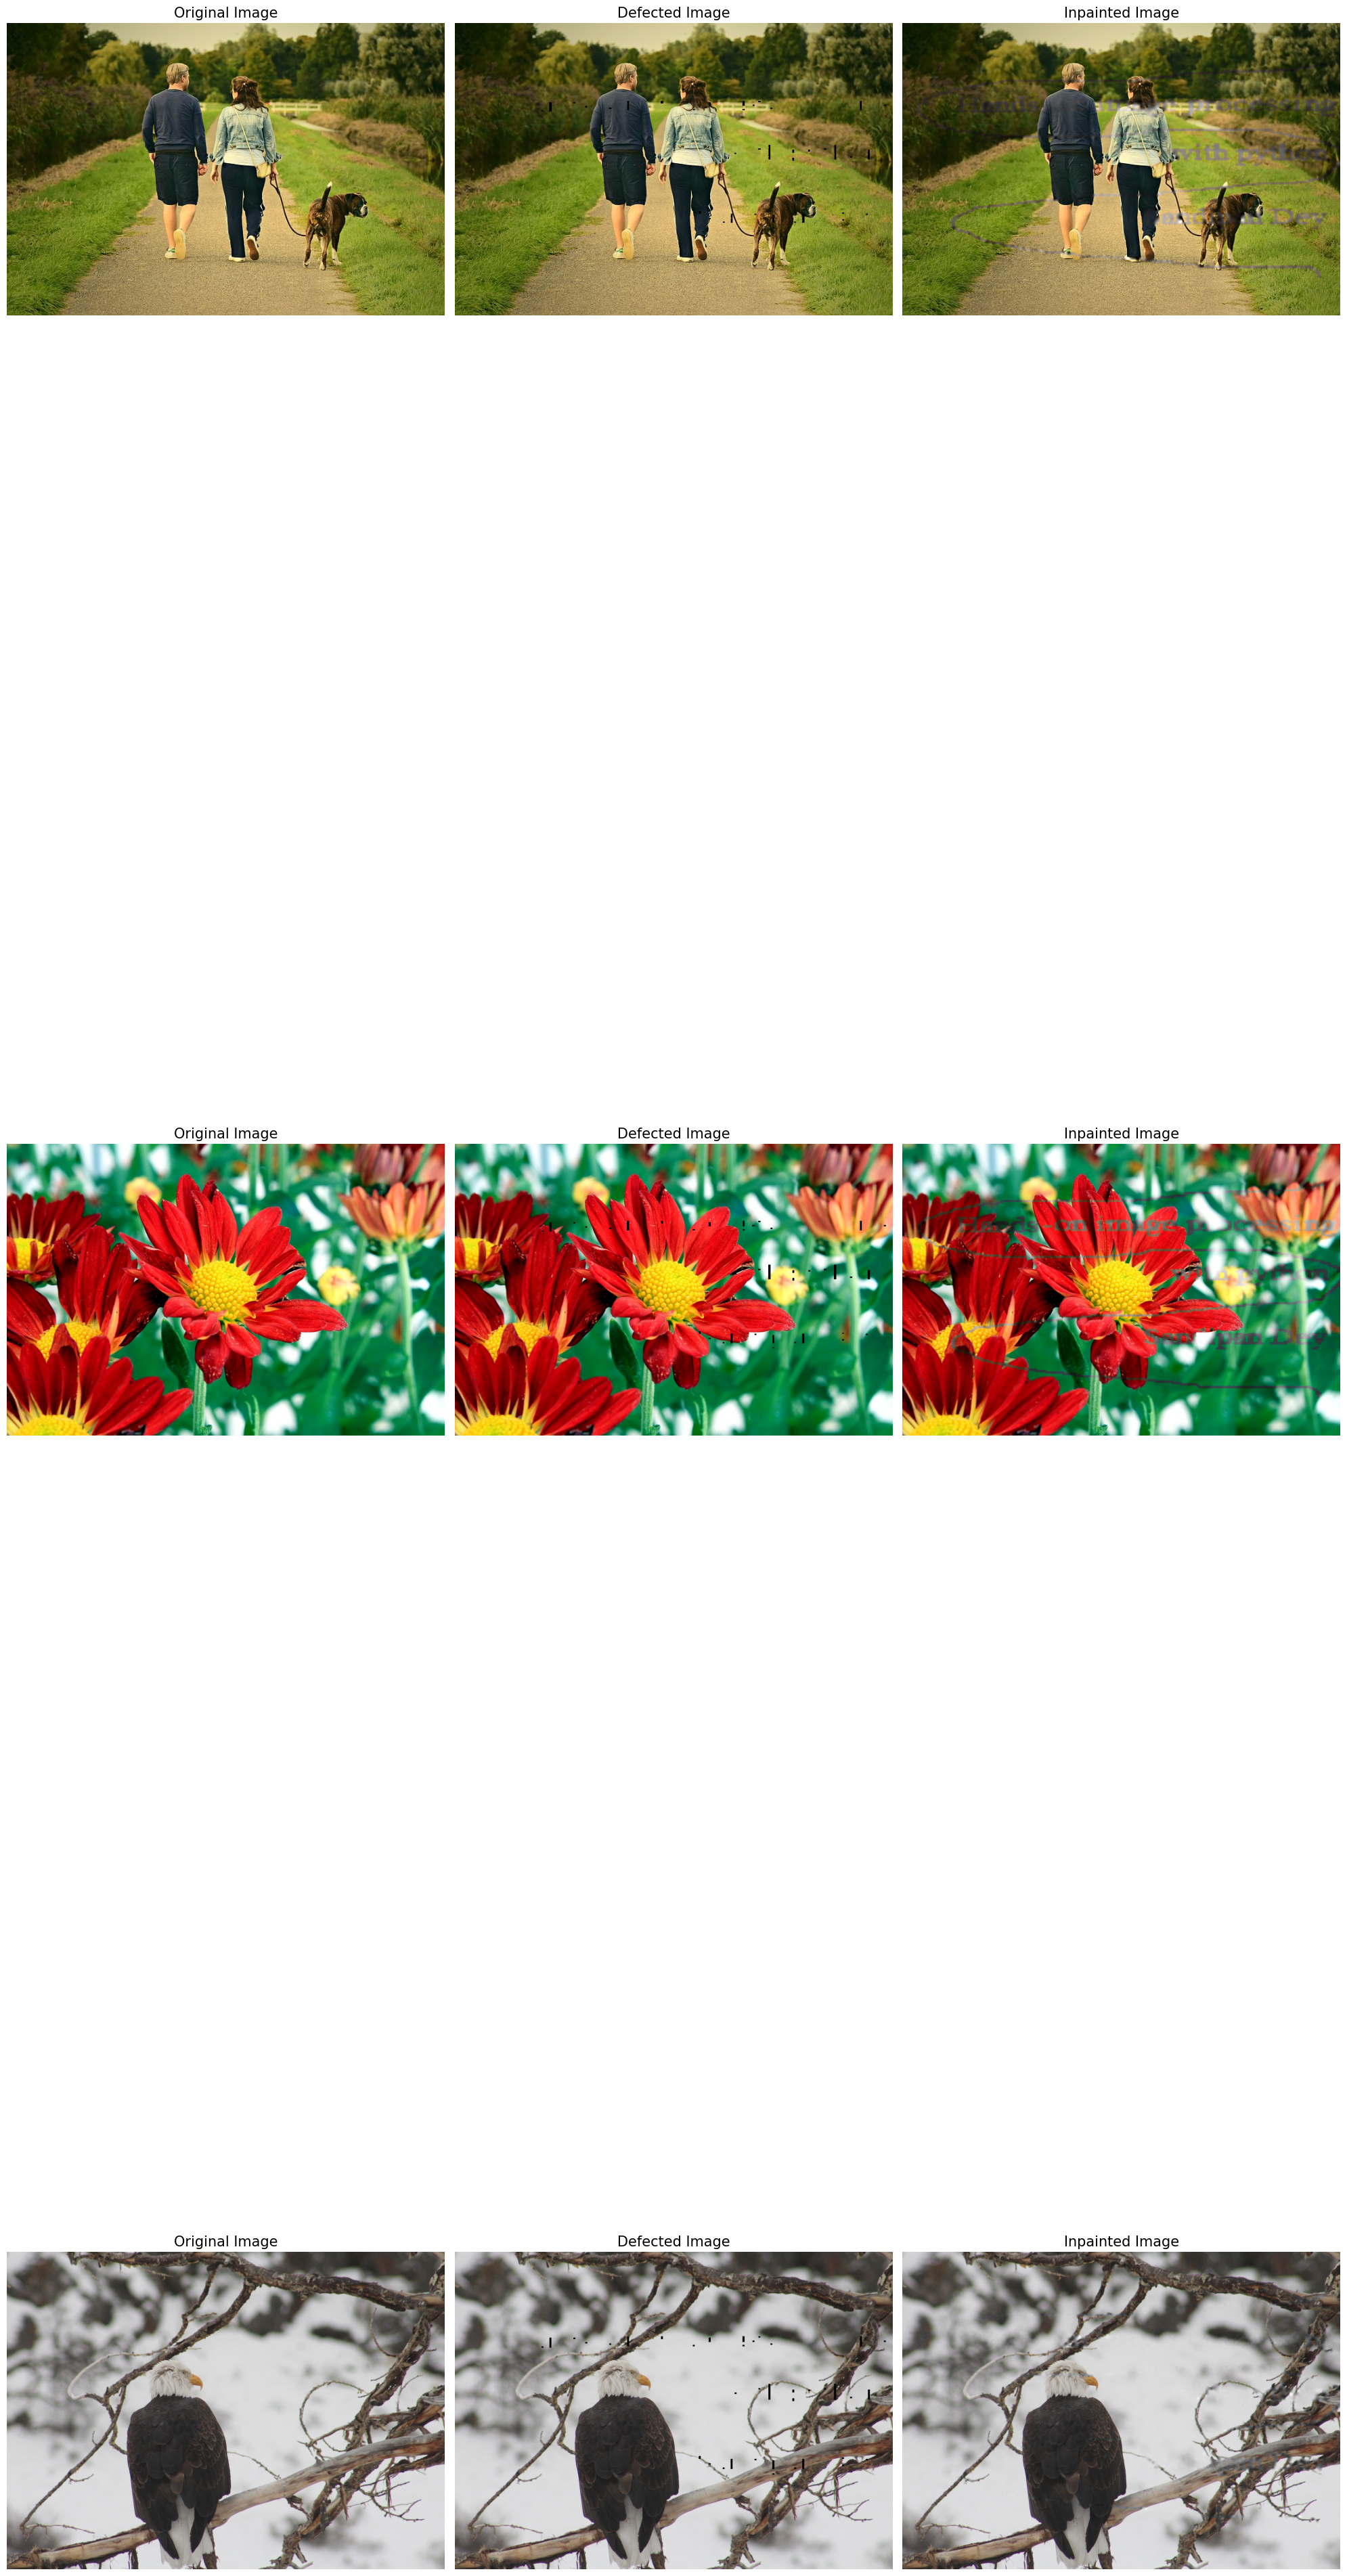

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from skimage import img_as_float
from skimage.restoration import inpaint
from skimage.transform import resize

# Đường dẫn tới các ảnh và mask
image_paths = [
    "/kaggle/input/data-btl-xla/images/men_dog.jpg",
    "/kaggle/input/data-btl-xla/images/flowers.jpg",
    "/kaggle/input/data-btl-xla/images/eagle.jpg"
]
mask_path = "/kaggle/input/data-btl-xla/images/lena_scratch_mask.jpg"

# Đọc và chuẩn bị mask
mask = rgb2gray(imread(mask_path))
mask[mask > 0.5] = 1  # Chuyển đổi mask thành nhị phân
mask[mask <= 0.5] = 0

# Lặp qua từng ảnh trong danh sách
fig, axes = plt.subplots(len(image_paths), 3, figsize=(20, 20 * len(image_paths)))
for i, image_path in enumerate(image_paths):
    # Đọc và chuẩn bị ảnh gốc
    image_orig = img_as_float(imread(image_path))

    # Đảm bảo mask có cùng kích thước với ảnh gốc
    if image_orig.shape[:2] != mask.shape:
        current_mask = resize(mask, image_orig.shape[:2], anti_aliasing=True)
    else:
        current_mask = mask

    # Tạo ảnh bị lỗi bằng cách gán giá trị 0 cho các vùng bị lỗi
    image_defect = image_orig.copy()
    image_defect[current_mask == 1] = 0  # Gán giá trị 0 cho các pixel ở vùng mask

    # Chuyển đổi mask thành 3 kênh
    mask_3d = np.stack([current_mask] * 3, axis=-1)

    # Sử dụng inpaint_biharmonic để khôi phục các vùng bị lỗi
    image_result = inpaint.inpaint_biharmonic(image_defect, mask_3d)

    # Hiển thị các ảnh: gốc, mask, ảnh bị lỗi, và ảnh đã khôi phục
    ax = axes[i]

    ax[0].set_title('Original Image', size=15)
    ax[0].imshow(image_orig)
    ax[0].axis('off')

    ax[1].set_title('Defected Image', size=15)
    ax[1].imshow(image_defect)
    ax[1].axis('off')

    ax[2].set_title('Inpainted Image', size=15)
    ax[2].imshow(image_result)
    ax[2].axis('off')

plt.tight_layout()
plt.show()


# Variational Image Processing

# Total Variation Denoising

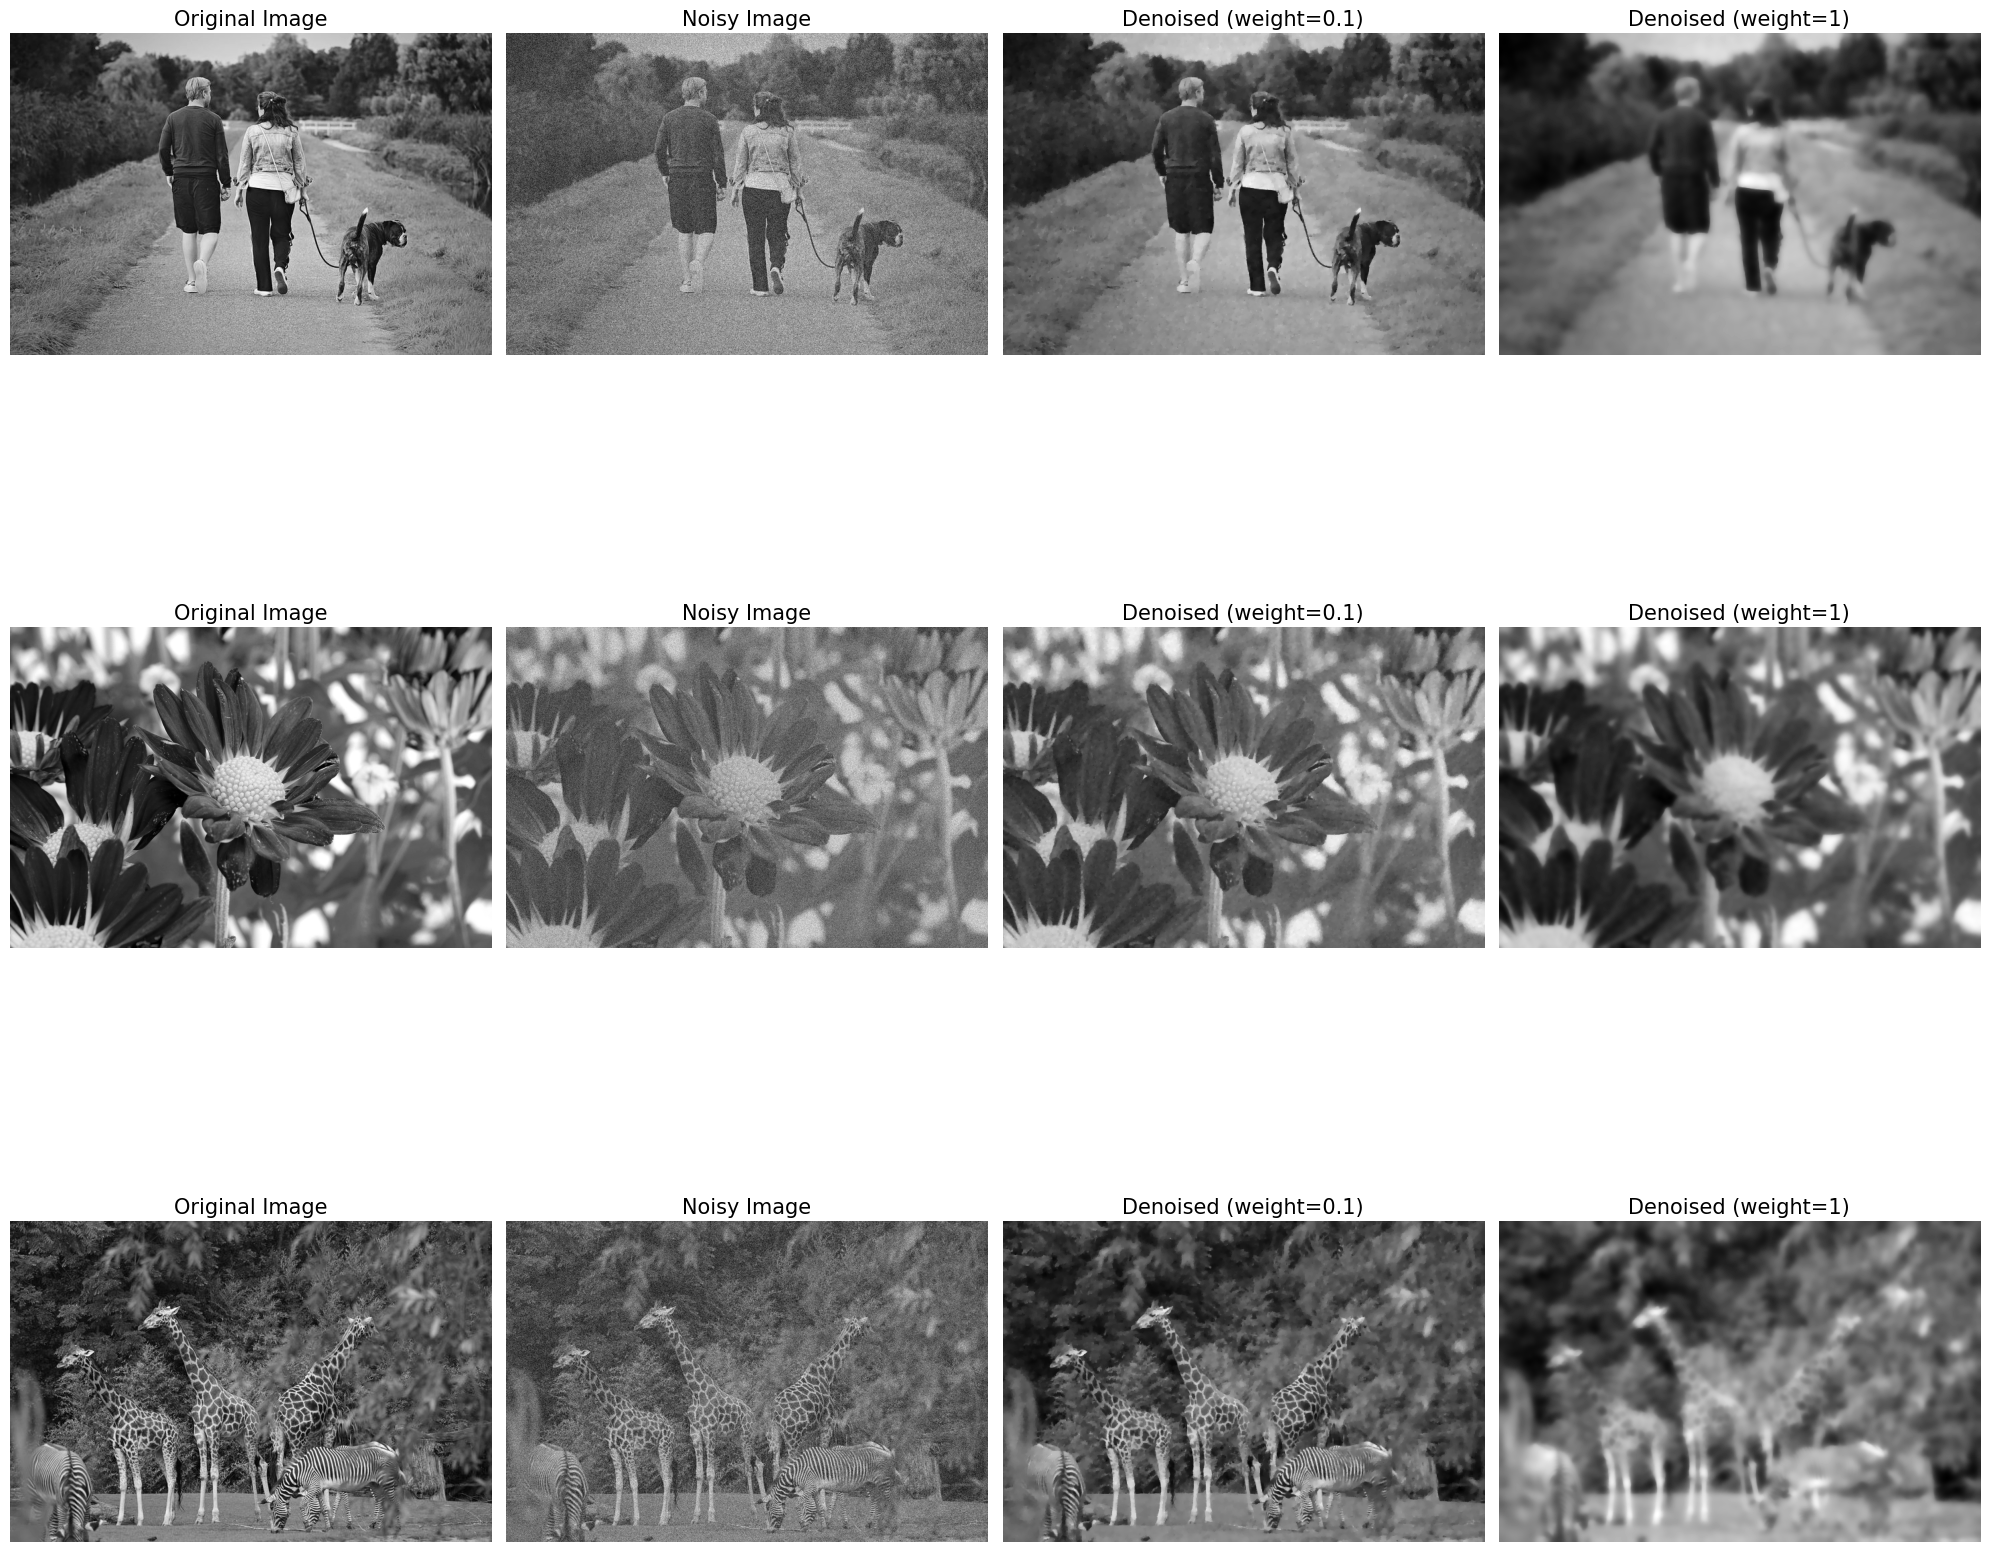

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, img_as_float
from skimage.restoration import denoise_tv_chambolle

# Đường dẫn tới các ảnh
image_paths = [
    "/kaggle/input/data-btl-xla/images/men_dog.jpg",
             "/kaggle/input/data-btl-xla/images/flowers.jpg",
             "/kaggle/input/data-btl-xla/images/giraffe_zebra.jpg"
]

# Kích thước hiển thị
fig, axes = plt.subplots(len(image_paths), 4, figsize=(20, 20))
for i, image_path in enumerate(image_paths):
    # Đọc và chuyển ảnh về dạng grayscale
    image = color.rgb2gray(img_as_float(io.imread(image_path)))
    
    # Thêm nhiễu Gaussian vào ảnh
    noisy_img = image + 0.5 * image.std() * np.random.randn(*image.shape)
    
    # Lọc nhiễu với các trọng số khác nhau
    denoised_img_0_1 = denoise_tv_chambolle(noisy_img, weight=0.1)
    denoised_img_1 = denoise_tv_chambolle(noisy_img, weight=1)
    
    # Hiển thị ảnh gốc, ảnh nhiễu, và ảnh sau khi lọc nhiễu với các trọng số khác nhau
    ax = axes[i]

    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Original Image', size=15)
    ax[0].axis('off')
    
    ax[1].imshow(noisy_img, cmap='gray')
    ax[1].set_title('Noisy Image', size=15)
    ax[1].axis('off')
    
    ax[2].imshow(denoised_img_0_1, cmap='gray')
    ax[2].set_title('Denoised (weight=0.1)', size=15)
    ax[2].axis('off')
    
    ax[3].imshow(denoised_img_1, cmap='gray')
    ax[3].set_title('Denoised (weight=1)', size=15)
    ax[3].axis('off')

plt.tight_layout()
plt.show()


# Texture synthesis

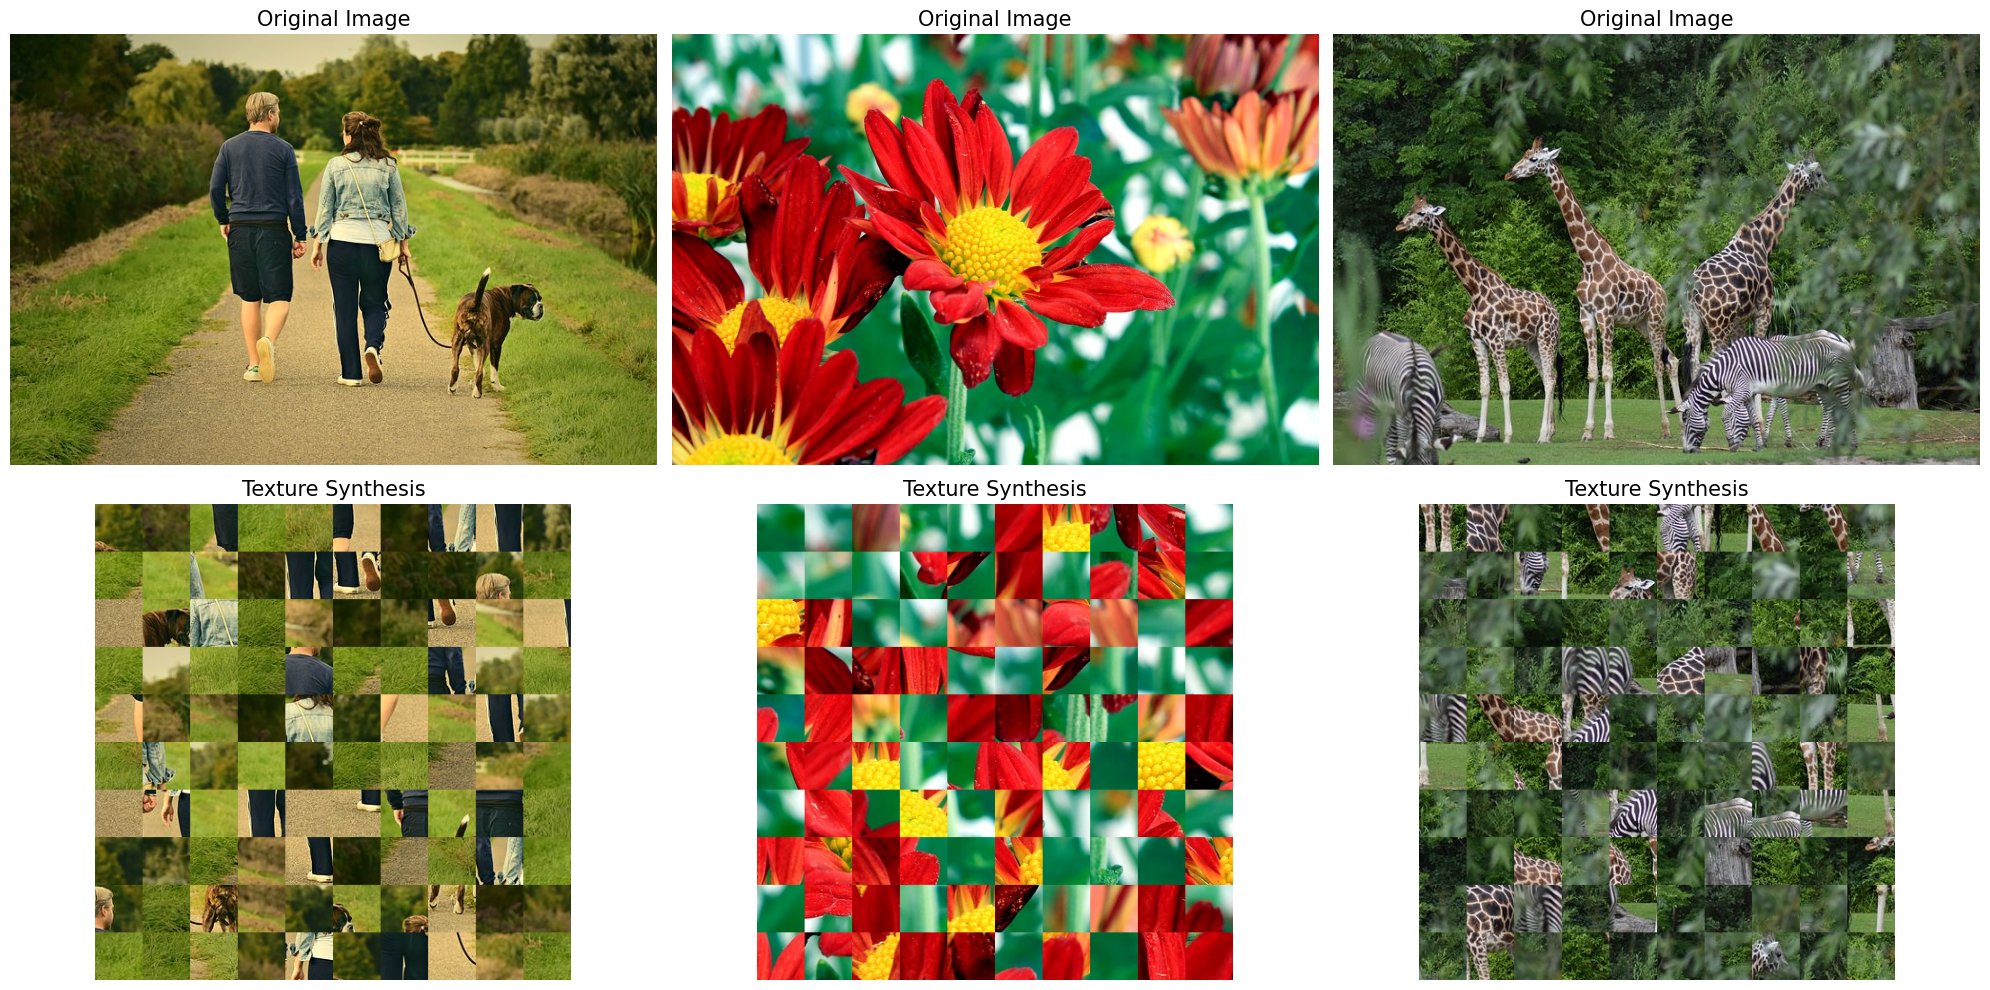

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Đường dẫn tới các ảnh
image_paths = [
    "/kaggle/input/data-btl-xla/images/men_dog.jpg",
             "/kaggle/input/data-btl-xla/images/flowers.jpg",
             "/kaggle/input/data-btl-xla/images/giraffe_zebra.jpg"
]

# Đọc ảnh và thêm vào danh sách
list_img = [Image.open(img_path) for img_path in image_paths]

# Hàm tạo texture synthesis từ ảnh gốc
def generate_texture(image, patch_size=(50, 50), output_size=(500, 500)):
    # Chuyển đổi ảnh thành mảng numpy
    img_np = np.array(image)
    height, width, channels = img_np.shape
    
    # Tạo mảng ngẫu nhiên từ các patch của ảnh
    texture = np.zeros((output_size[0], output_size[1], channels), dtype=img_np.dtype)
    
    for i in range(0, output_size[0], patch_size[0]):
        for j in range(0, output_size[1], patch_size[1]):
            # Chọn ngẫu nhiên tọa độ của một patch trong ảnh gốc
            x = np.random.randint(0, height - patch_size[0])
            y = np.random.randint(0, width - patch_size[1])
            
            # Thêm patch vào texture synthesis
            texture[i:i + patch_size[0], j:j + patch_size[1]] = img_np[x:x + patch_size[0], y:y + patch_size[1]]
    
    return texture

# Tạo cửa sổ hiển thị ảnh gốc và texture synthesis
fig, axes = plt.subplots(2, len(list_img), figsize=(20, 10))

for i, image in enumerate(list_img):
    # Hiển thị ảnh gốc
    axes[0, i].imshow(image)
    axes[0, i].set_title("Original Image", size=15)
    axes[0, i].axis('off')
    
    # Tạo và hiển thị ảnh texture synthesis
    texture_img = generate_texture(image)
    axes[1, i].imshow(texture_img)
    axes[1, i].set_title("Texture Synthesis", size=15)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()
